<a href="https://colab.research.google.com/github/Denbergvanthijs/hu-reinforcement-learning-gym/blob/master/1_Hogeschool_Utrecht_Reinforcement_Learning_project_Q_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Reinforcement Learning project - Q-Learning




## Aim
In this lab we are going to solve two simple [OpenAI Gym](https://gym.openai.com/) environments using [Q-Learning](https://en.wikipedia.org/wiki/Q-learning). Specifically, the [CartPole-v0](https://gym.openai.com/envs/CartPole-v0/) and [MountainCar-v0](https://gym.openai.com/envs/MountainCar-v0/) environments.

We will try to create a table containing the expected reward for each combination of a *state* and *action*. We will use this table to choose the (hopefully) best action given the state the system is in.

While this may not be the most advanced or complicated model there is, it is perfect for this task! Furthermore, it can be trained in a relatively short time!

## Runtime and environment
This [Jupyter Notebook](https://jupyterlab.readthedocs.io/en/latest/) was made to run on Google Colab. For this training, we recommend using the Google Colab environment.

Please read the [instructions on Google Colab](https://medium.com/swlh/the-best-place-to-get-started-with-ai-google-colab-tutorial-for-beginners-715e64bb603b) to get started quickly. It behaves similar to Jupyter Notebook, Jupyter Hub and Jupyter Lab, so if you have any experience with those, you're good to go!

Some notes on Google Colab:
- **Processes in Google Colab won't run forever**. These may be terminated at any time when the platform is crowded, and *will definitely* terminate after 12 hours. To maintain persistency, you can attach the session to **Google Drive** and have your models persist themselves to the Google Drive periodically.
- You can enable GPU or TPU support! You can find this option under *Runtime* -> *Change runtime type*.
- After installing dependencies, you need to restart the runtime in order to actually use them.

If you want to run the code on your own platform or system, you need to keep a few things in mind:
- The dependencies you need to install may differ from the ones we installed here. The installed dependencies are suitable for Google Colab, Ubuntu, and Debian.
- Since Google Colab isn't attached to a monitor, we render the output to a video file. On your own machine the built-in render method from OpenAI's Gym may suffice.
- The default paths use Google Drive! Change these.

## Info Support
This assignment was developed by Info Support. Looking for a graduation project or job? Check out their website: https://carriere.infosupport.com/



# Preparation

Some dependencies need to be installed for the code to work. Furthermore, we will define some methods which allow us to show the OpenAI Gym renderings in this (headless) Google Colab environment.

You only have to run these and don't need to change any of the code.

In [1]:
# Install dependencies
"""Note: if you are running this code on your own machine, you probably don't need all of these.
   Start with 'pip install gym' and install more packages if you run into errors."""
!apt-get update > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg cmake > /dev/null 2>&1

!pip install gym pyvirtualdisplay > /dev/null 2>&1
!pip install --upgrade setuptools 2>&1
!pip install ez_setup > /dev/null 2>&1
!pip install gym[atari] > /dev/null 2>&1
!pip install colabgymrender

Requirement already up-to-date: setuptools in /usr/local/lib/python3.7/dist-packages (57.0.0)


In [2]:
# Imports for helper functions
import base64
import io
import math
from pathlib import Path

import gym
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from colabgymrender.recorder import Recorder
from google.colab import drive
from gym.wrappers import Monitor
from IPython import display as ipythondisplay
from IPython.display import HTML
from pyvirtualdisplay import Display

In [3]:
# Mount your Google Drive. By doing so, you can store any output, models, videos, and images persistently.

# Note: in this new version of the notebook, we no longer render video's to Google Drive, but to a temporary storage within the container!
# Please copy files from /tmp/HU_RL/ to /content/gdrive/My Drive/<my_path> that you want to keep, or just download them through the viewer!

enable_gdrive = False   # Switch to indicate whether Google Drive should be mounted.

if enable_gdrive:
    drive.mount('/content/gdrive')

In [4]:
# Create a directory to store the data for this lab. Feel free to change this.
if enable_gdrive:
    drive_path = Path('/content/gdrive/My Drive/Colab Notebooks/HU_RL/part1')
    drive_path.mkdir(parents=True, exist_ok=True)

tmp_path_on_container = Path('/tmp/HU_RL/')
video_path = tmp_path_on_container / 'video'
video_path.mkdir(parents=True, exist_ok=True)

In [5]:
# Define helper functions to visually show what the models are doing.
%matplotlib inline

gym.logger.set_level(gym.logger.ERROR)

display = Display(visible=0, size=(1400, 900))
display.start()

# def show_video():
#     # Display the stored video file
#     # Credits: https://star-ai.github.io/Rendering-OpenAi-Gym-in-Colaboratory/
#     mp4list = list(data_path.glob('video/*.mp4'))
#     if len(mp4list) > 0:
#         mp4 = mp4list[-1]
#         video = io.open(mp4, 'r+b').read()
#         encoded = base64.b64encode(video)
#         ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
#                 loop controls style="height: 400px;">
#                 <source src="data:video/mp4;base64,{0}" type="video/mp4" />
#             </video>'''.format(encoded.decode('ascii'))))
#     else: 
#         print('Could not find video')

# def record_episode(idx):
#     # This determines which episodes to record.
#     # Since the video rendering in the OpenAI Gym is a bit buggy, we simply override it and decide
#     # whether or not to render inside of our training loop.
#     return True

def video_env(env):
    # Wraps the environment to write its output to a video file
    # env = Monitor(env, video_path, video_callable=record_episode, force=True)
    env = Recorder(env, video_path, 15)     # Render at 15 FPS. Try to keep this low, to prevent hitting quotas.
    return env

# Test the environment

In [6]:
print("""We will use a basic OpenAI Gym examle: CartPole-v0.
In this example, we will try to balance a pole on a cart.
This is similar to kids (and.. grown-ups) trying to balance sticks on their hands.

Check out the OpenAI Gym documentation to learn more: https://gym.openai.com/docs/""")

# Create the desired environment
env = gym.make("CartPole-v0")

# Wrap the environment, to make sure we get to see a fancy video
env = video_env(env)

# # Before you can use a Gym environment, it needs to be reset.
state = env.reset()

# Perform random actions untill we drop the stick. Just as an example.
done = False
while not done:
    # env.render()
    # The action_space contains all possible actions we can take.
    random_action = env.action_space.sample() 

    # After each action, we end up in a new state and receive a reward.
    # When we drop the pole (more than 12 degrees), or balance it long enough (200 steps),
    # or drive off the screen, done is set to True.
    state, reward, done, info = env.step(random_action)

# Show the results!
env.play()
# env.close()
# show_video()

We will use a basic OpenAI Gym examle: CartPole-v0.
In this example, we will try to balance a pole on a cart.
This is similar to kids (and.. grown-ups) trying to balance sticks on their hands.

Check out the OpenAI Gym documentation to learn more: https://gym.openai.com/docs/


In [7]:
# Neat, it did something (randomly)! 

# In order to train the system, we will try to predict the reward a certain actions yields given the state of the system.
# But what is the state anyway?

# In this environment, the state represents the cart's position and velocity, and the pole's angle and velocity.

# Let's check out the current state
print(f'Cart position: {state[0]} (range: [-4.8, 4.8])')
print(f'Cart velocity: {state[1]} (range: [-inf, inf])')
print(f'Pole angle: {state[2]} (range: [-0.418, 0.418])')
print(f'Pole velocity: {state[3]} (range [-inf, inf])')

# You can find out the minimum and maximum possible observation values using:
print(f'Low observation space:', env.observation_space.low)
print(f'High observation space:', env.observation_space.high)

Cart position: -0.12079523248508685 (range: [-4.8, 4.8])
Cart velocity: -0.604516217223636 (range: [-inf, inf])
Pole angle: 0.212202016101258 (range: [-0.418, 0.418])
Pole velocity: 1.1680925884062912 (range [-inf, inf])
Low observation space: [-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38]
High observation space: [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38]


# Implement Q-Learning

## Task
Implement Q-Learning and find suitable parameters to reach a 200 reward.

In [8]:
# Define parameters - Fill in the dots

num_episodes = 20_000
num_episodes_between_status_update = 5_000
num_episodes_between_videos = num_episodes

learning_rate = 0.1          # also known as: alpha
discount = 0.95              # also known as: gamma
epsilon = 0.99

# Epsilon decay
pass    # Optionally, add parameters for epsilon decay here

# Discretization
pass    # You can add parameters to discretize states here

In [9]:
## Q-Table creation

# As seen before, the state consists of 4 floating point values.
# It makes sense to discretize these values (read: place them in buckets), to reduce the state space and therefore the Q-table size
# state_shape = [5, 101, 203, 157]      # For instance: [4, 4, 6, 6], or [10] * 4, or [200, 200, 100, 100]
# state_shape = [5, 5, 5, 5]      # For instance: [4, 4, 6, 6], or [10] * 4, or [200, 200, 100, 100]
state_shape = [35, 35, 51, 51]      # For instance: [4, 4, 6, 6], or [10] * 4, or [200, 200, 100, 100]

# Define the initial Q table as a random uniform distribution
q_table = np.random.uniform(low=-1, high=0, size=(state_shape + [env.action_space.n]))

space_space = np.vstack((env.observation_space.low, env.observation_space.high, state_shape)).T
# space_space[1,:2] = np.clip(space_space[1,:2], -2, 2)
# space_space[3,:2] = np.clip(space_space[3,:2], -2, 2)
space_space[:,:2] = np.clip(space_space[:,:2], -10, 10)
space_space_linspace = [np.linspace(low, high, num=int(num)) for low, high, num in space_space]
print(len(space_space_linspace), [len(space_linspace) for space_linspace in space_space_linspace])

print('Q table shape:', q_table.shape)

4 [35, 35, 51, 51]
Q table shape: (35, 35, 51, 51, 2)


# Train


In [10]:
def discretize_state(state, bins=space_space_linspace):
    # A Q-table cannot practically handle infinite states, so limit the state space by
    # discretizing the state into buckets.
    # discrete_state = np.array([np.digitize(s, bun) for s, bun in zip(state, bins)])
    discrete_state = np.array([np.searchsorted(bun, s, side="right") for s, bun in zip(state, bins)])
    # print(state)
    # print(discrete_state)
    return tuple(discrete_state.astype(np.int))

def take_action(discrete_state, epsilon, q_table=q_table,
                rng=np.random.default_rng(), env=env):
    # Take an action to either explore or exploit.
    if rng.random() > epsilon:
      # Exploit
      action = np.argmax(q_table[discrete_state])
    else:
      # Explore
      action = rng.integers(env.action_space.n)
    return action

def estimated_max_for_next_state(discrete_state, q_table=q_table):
    # What's the best expected Q-value for the next state?
    estimated_max = np.max(q_table[discrete_state])
    return estimated_max

def new_q_value(discrete_state, action, max_future_q, reward, q_table=q_table,
                learning_rate=learning_rate, discount=discount):
    # Calculate the new Q-value
    current_q = q_table[discrete_state + (action,)]
    new_q = current_q + learning_rate * (reward + discount * max_future_q - current_q)
    return new_q

def decayed_epsilon(episode, epsilon_max: float = 0.99, epsilon_min: float = 0.01, steps: int = 10_000):
    if episode > steps:
        return epsilon_min
    else:
        epsilon_per_step = (epsilon_max - epsilon_min) / steps
        return epsilon_max - epsilon_per_step * episode

In [11]:
# Time to train the system

for episode in range(num_episodes):
    if (episode + 1) % num_episodes_between_videos == 0:
        env.resume()
    else:
        env.pause()
      
    state = env.reset() # Don't forget to reset the environment between episodes
    current_state_disc = discretize_state(state)

    reward_sum = 0
    done = False
    while not done:
        # env.render()

        # Take an action by exploration or exploitation
        action = take_action(current_state_disc, epsilon)
        new_state, reward, done, info = env.step(action)
        new_state_disc = discretize_state(new_state)

        # Calculate the total reward
        reward_sum += reward

        if not done:
            # Retrieve the maximum estimated value for the next state
            max_future_q = estimated_max_for_next_state(new_state_disc)

            # Calculate the new value (note: Bellman equation)
            # Added reward as argument for Bellman equation (Casper & Thijs)
            new_q = new_q_value(current_state_disc, action, max_future_q, reward)
            q_table[current_state_disc + (action,)] = new_q
        else:
            # # Render the video
            # if (episode + 1) % num_episodes_between_status_update == 0:
            #     env.render()
            #     print(epsilon)
            #     print(f'Total reward at episode {episode + 1}: {reward_sum}')
            pass

        # Prepare for the next loop
        current_state_disc = new_state_disc

    # Decay epsilon
    epsilon = decayed_epsilon(episode)
    if (episode + 1) % num_episodes_between_status_update == 0:
        print(f'Finished episode {episode + 1} / {num_episodes} with reward {reward_sum}')

env.play()
env.close()

Finished episode 5000 / 20000 with reward 77.0
Finished episode 10000 / 20000 with reward 176.0
Finished episode 15000 / 20000 with reward 130.0
Finished episode 20000 / 20000 with reward 127.0


# MountainCar


Now apply the things you've learned to the MountainCar problem. Please note that the observable space differs from the previous problem. Thus, before you start training, you need to learn more about the/this new environment.

Here is some code to help you get started...

In [12]:
# Create the desired environment
env = gym.make("MountainCar-v0")

# Wrap the environment, to make sure we get to see a fancy video
env = video_env(env)

# Before you can use a Gym environment, it needs to be reset.
state = env.reset()

learning_rate = 0.2
discount = 0.99
num_episodes = 20_000
num_episodes_between_videos = 20_000
num_episodes_between_status_update = 2_500
epsilon = 0.99
epsilon_max = 0.99
epsilon_min = 0.01
steps = 10_000

In [13]:
# Let's check out the current state
print(f'Car Position: {state[0]}')
print(f'Car Velocity: {state[1]}')

# You can find out the minimum and maximum possible observation values using:
print(f'Low observation space:', env.observation_space.low)
print(f'High observation space:', env.observation_space.high)

Car Position: -0.48937890497052977
Car Velocity: 0.0
Low observation space: [-1.2  -0.07]
High observation space: [0.6  0.07]


In [14]:
state_shape = [51, 51]      # For instance: [4, 4, 6, 6], or [10] * 4, or [200, 200, 100, 100]

# Define the initial Q table as a random uniform distribution
q_table = np.random.uniform(low=-1, high=0, size=(state_shape + [env.action_space.n]))

space_space = np.vstack((env.observation_space.low, env.observation_space.high, state_shape)).T

space_space[:,:2] = np.clip(space_space[:,:2], -1.3, 0.7)
space_space_linspace = [np.linspace(low, high, num=int(num)) for low, high, num in space_space]
print(len(space_space_linspace), [len(space_linspace) for space_linspace in space_space_linspace])

print('Q table shape:', q_table.shape)

2 [51, 51]
Q table shape: (51, 51, 3)


In [15]:
# Time to train the system

for episode in range(num_episodes):
    if (episode + 1) % num_episodes_between_videos == 0:
        env.resume()
    else:
        env.pause()
    state = env.reset() # Don't forget to reset the environment between episodes
    current_state_disc = discretize_state(state, bins=space_space_linspace)

    reward_sum = 0
    done = False
    while not done:

        # Take an action by exploration or exploitation
        action = take_action(current_state_disc, epsilon, q_table=q_table, env=env)
        new_state, reward, done, info = env.step(action)
        new_state_disc = discretize_state(new_state, bins=space_space_linspace)

        # Calculate the total reward
        reward_sum += reward

        if not done:
            # Retrieve the maximum estimated value for the next state
            max_future_q = estimated_max_for_next_state(new_state_disc, q_table=q_table)

            # Calculate the new value (note: Bellman equation)
            # Added reward as argument for Bellman equation (Casper & Thijs)
            new_q = new_q_value(current_state_disc, action, max_future_q, reward,
                                q_table=q_table, learning_rate=learning_rate,
                                discount=discount)
            q_table[current_state_disc + (action,)] = new_q
        else:
            # Render the video
            if (episode + 1) % num_episodes_between_status_update == 0:
                # env.render()
                print(f'Total reward at episode {episode + 1}: {reward_sum}; epsilon={epsilon}')

        # Prepare for the next loop
        current_state_disc = new_state_disc
    
    # Decay epsilon
    epsilon = decayed_epsilon(episode, epsilon_max=epsilon_max, epsilon_min=epsilon_min, steps=steps)

# Show the results!
env.play()
env.close()
# show_video()

Total reward at episode 2500: -200.0; epsilon=0.745196
Total reward at episode 5000: -200.0; epsilon=0.5001960000000001
Total reward at episode 7500: -200.0; epsilon=0.255196
Total reward at episode 10000: -158.0; epsilon=0.010195999999999983
Total reward at episode 12500: -153.0; epsilon=0.01
Total reward at episode 15000: -189.0; epsilon=0.01
Total reward at episode 17500: -152.0; epsilon=0.01
Total reward at episode 20000: -112.0; epsilon=0.01


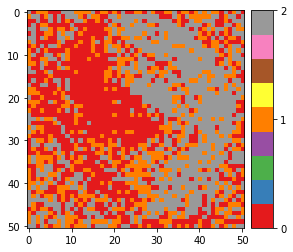

In [16]:
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import ticker

ax = plt.subplot()
im = ax.imshow(q_table.argmax(axis=2), cmap="Set1")

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="10%", pad=0.1)

cb = plt.colorbar(im, cax=cax)
cb.ax.locator_params(nbins=3)


plt.show()